# Comprehensive Analysis of UPI Transactions Dataset


This notebook provides a comprehensive analysis of the UPI Transactions Dataset. The analysis covers various aspects including data cleaning, descriptive statistics, transaction patterns, predictive modeling, anomaly detection, feature importance analysis, and clustering analysis. The goal is to derive meaningful insights and build robust predictive models from the dataset.


## Importing Neccessary Models and Dataset

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

df = pd.read_csv('data/transactions.csv')


/home/debjit/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



## Data Overview and Cleaning


In [2]:
print("Initial Data Overview:")
print(df.info())
print(df.describe())

print("Missing Values:")
print(df.isnull().sum())

df['Timestamp'] = pd.to_datetime(df['Timestamp'])


Initial Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Transaction ID   1000 non-null   object 
 1   Timestamp        1000 non-null   object 
 2   Sender Name      1000 non-null   object 
 3   Sender UPI ID    1000 non-null   object 
 4   Receiver Name    1000 non-null   object 
 5   Receiver UPI ID  1000 non-null   object 
 6   Amount (INR)     1000 non-null   float64
 7   Status           1000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 62.6+ KB
None
       Amount (INR)
count   1000.000000
mean    4999.022930
std     2873.484534
min       28.520000
25%     2521.620000
50%     4951.435000
75%     7315.835000
max     9993.060000
Missing Values:
Transaction ID     0
Timestamp          0
Sender Name        0
Sender UPI ID      0
Receiver Name      0
Receiver UPI ID    0
Amount (INR)       0
Status     


## Feature Engineering


In [3]:
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Hour'] = df['Timestamp'].dt.hour



## Descriptive Statistics


In [4]:
print("Descriptive Statistics:")
print(df.describe())


Descriptive Statistics:
                           Timestamp  Amount (INR)    DayOfWeek         Hour
count                           1000   1000.000000  1000.000000  1000.000000
mean   2024-06-19 01:08:56.956000256   4999.022930     2.850000    11.504000
min              2024-06-04 00:15:27     28.520000     0.000000     0.000000
25%              2024-06-11 17:59:49   2521.620000     1.000000     6.000000
50%              2024-06-19 00:09:41   4951.435000     3.000000    12.000000
75%    2024-06-26 07:52:29.249999872   7315.835000     5.000000    17.000000
max              2024-07-03 23:15:06   9993.060000     6.000000    23.000000
std                              NaN   2873.484534     1.948152     6.759118



## Transaction Patterns and Trends


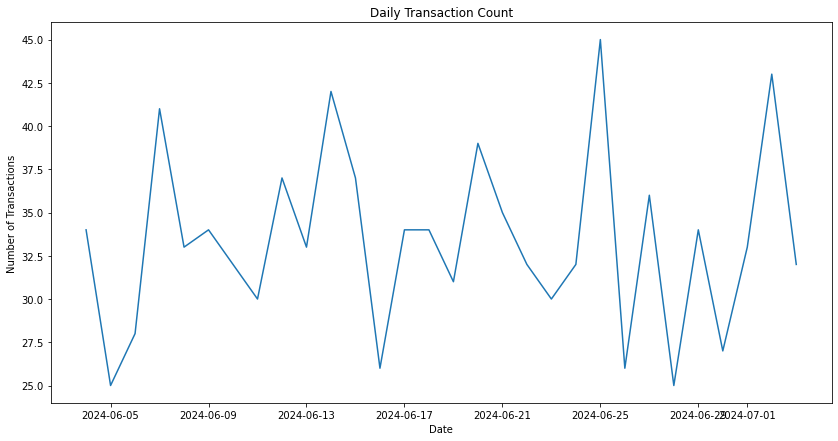

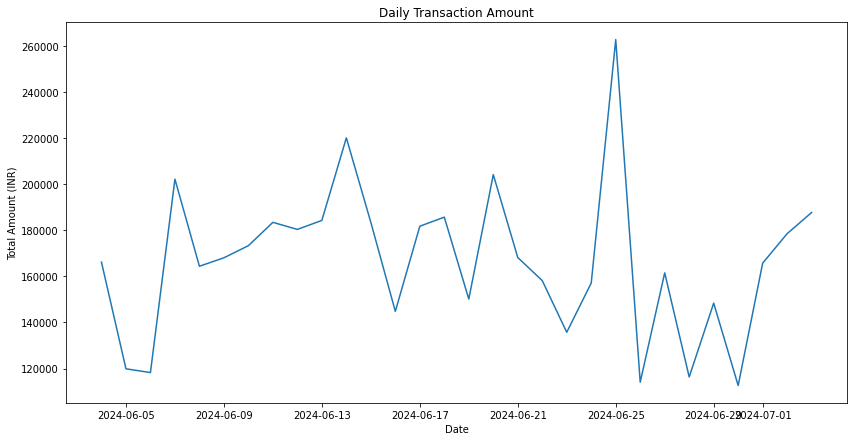

In [5]:
plt.figure(figsize=(14, 7))
df['Timestamp'].groupby(df['Timestamp'].dt.date).count().plot(kind='line')
plt.title('Daily Transaction Count')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.show()

plt.figure(figsize=(14, 7))
df['Amount (INR)'].groupby(df['Timestamp'].dt.date).sum().plot(kind='line')
plt.title('Daily Transaction Amount')
plt.xlabel('Date')
plt.ylabel('Total Amount (INR)')
plt.show()



## Time Series Analysis

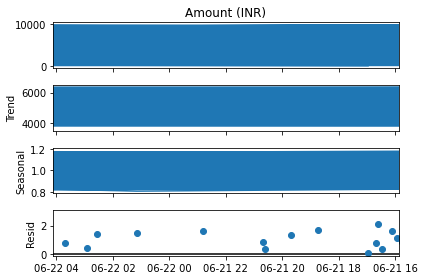

In [6]:
df.set_index('Timestamp', inplace=True)
decomposition = seasonal_decompose(df['Amount (INR)'], model='multiplicative', period=30)
decomposition.plot()
plt.show()
df.reset_index(inplace=True)



## Predictive Modeling for Transaction Success/Failure


In [7]:

df['Status'] = df['Status'].apply(lambda x: 1 if x == 'SUCCESS' else 0)

le = LabelEncoder()
df['Sender Name'] = le.fit_transform(df['Sender Name'])
df['Receiver Name'] = le.fit_transform(df['Receiver Name'])
df['Sender UPI ID'] = le.fit_transform(df['Sender UPI ID'])
df['Receiver UPI ID'] = le.fit_transform(df['Receiver UPI ID'])

X = df.drop(['Transaction ID', 'Timestamp', 'Status'], axis=1)
y = df['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50       153
           1       0.48      0.49      0.49       147

    accuracy                           0.49       300
   macro avg       0.49      0.49      0.49       300
weighted avg       0.49      0.49      0.49       300

Confusion Matrix:
[[76 77]
 [75 72]]



## Feature Importance Analysis


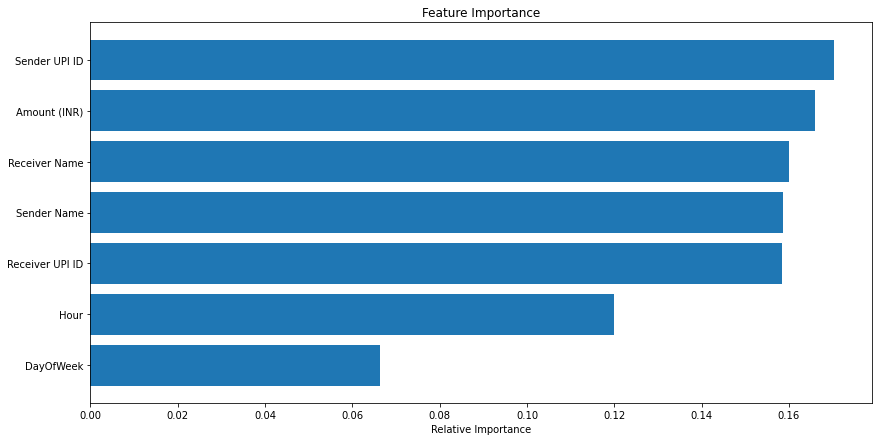

In [8]:

importances = clf.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(14, 7))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



## Fraud Detection Analysis


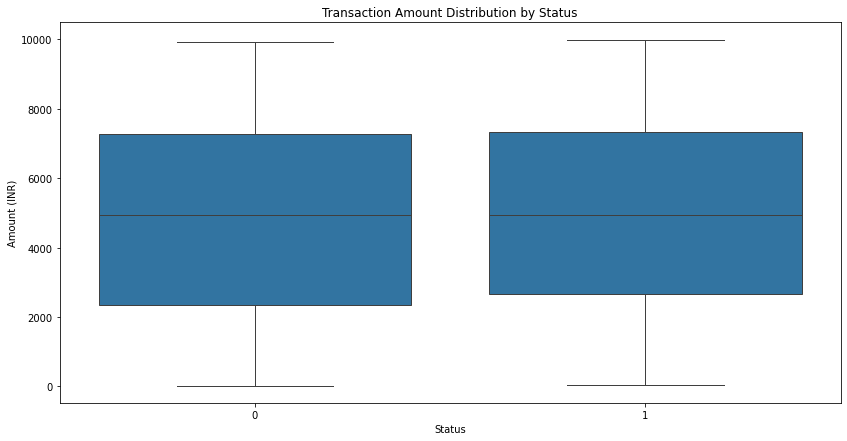

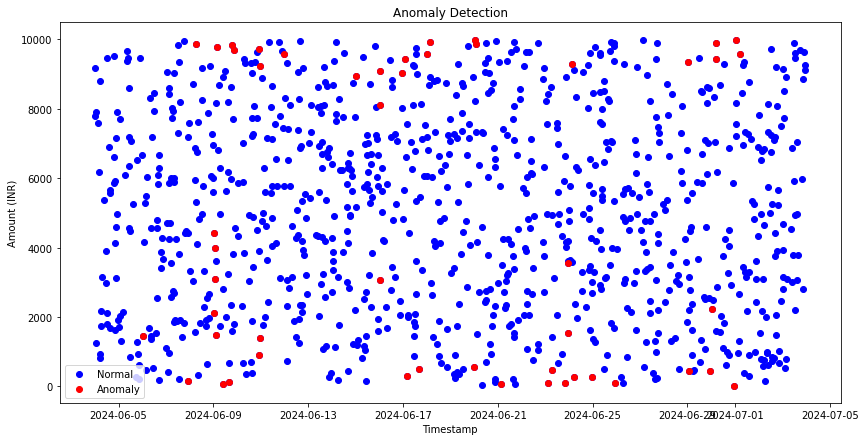

In [9]:

plt.figure(figsize=(14, 7))
sns.boxplot(x='Status', y='Amount (INR)', data=df)
plt.title('Transaction Amount Distribution by Status')
plt.show()

iso_forest = IsolationForest(contamination=0.05)
df['anomaly'] = iso_forest.fit_predict(df[['Amount (INR)', 'DayOfWeek', 'Hour']])

anomalies = df[df['anomaly'] == -1]
plt.figure(figsize=(14, 7))
plt.scatter(df['Timestamp'], df['Amount (INR)'], c='blue', label='Normal')
plt.scatter(anomalies['Timestamp'], anomalies['Amount (INR)'], c='red', label='Anomaly')
plt.title('Anomaly Detection')
plt.xlabel('Timestamp')
plt.ylabel('Amount (INR)')
plt.legend()
plt.show()



## Clustering Analysis


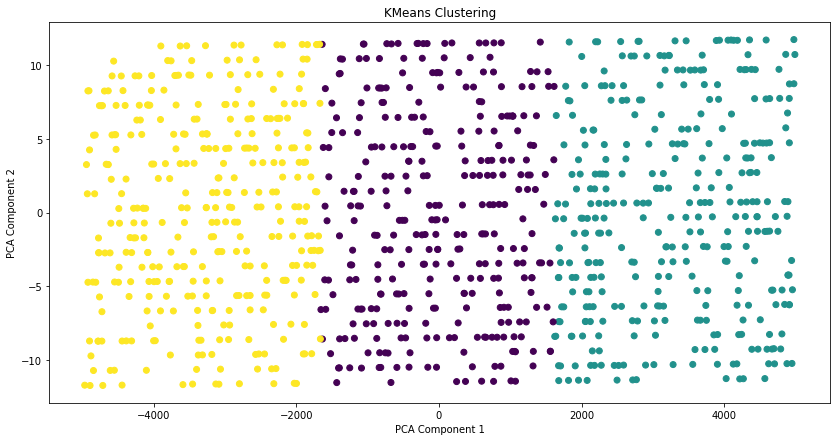

In [10]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df[['Amount (INR)', 'DayOfWeek', 'Hour']])

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_pca)

plt.figure(figsize=(14, 7))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df['Cluster'])
plt.title('KMeans Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()



## Conclusion
In this notebook, an in-depth analysis of the UPI Transactions Dataset is performed. The key insights derived include:
- The daily patterns and trends of transactions.
- A predictive model for transaction success with feature importance analysis.
- Anomaly detection for identifying potential fraudulent transactions.
- Clustering of transactions into distinct groups.

